# Słowo wstępu

Notatnik jest podzielony na trzy główne sekcje:
- preprocessing - wykonany zbiorczo dla wszystkich modeli. Jeżeli jakiś model wymagał dodatkowej obróbki danych to została ona wykonana w jego sekcji. 
- regresja logistyczna:
    - sekcje odpowiednio: definicja modeli, trening, ewaluacja, wizualizacja wyników, wnioski. Na końcu umieściliśmy walidację krzyżową - wykonaliśmy ją raz, obecnie jest zakomentowana.
    - wykorzystano zbiór "e6" - największy 
- xgb:
    - sekcje jw.
    - wykorzystano zbiór średniej wielkości "e5"



In [1]:
pip install h2o_pysparkling_3.2

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pyspark
num_of_threads = 6

spark = pyspark.sql.SparkSession.builder.appName("tbd") \
    .master(f"local[{num_of_threads}]") \
    .config("spark.jars.packages", "com.microsoft.azure:synapseml_2.12:0.9.5") \
    .config("spark.jars.repositories", "https://mmlspark.azureedge.net/maven") \
    .config("spark.executor.cores", num_of_threads) \
    .getOrCreate()
from pysparkling import *
import h2o
hc = H2OContext.getOrCreate()

import pandas as pd

Connecting to H2O server at http://e3593c4630dc:54323 ... successful.


H2O_cluster_uptime:,19 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.4
H2O_cluster_version_age:,3 days
H2O_cluster_name:,sparkling-water-jovyan_local-1673277815543
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"



Sparkling Water Context:
 * Sparkling Water Version: 3.38.0.4-1-3.2
 * H2O name: sparkling-water-jovyan_local-1673277815543
 * cluster size: 1
 * list of used nodes:
  (executorId, host, port)
  ------------------------
  (0,172.17.0.2,54321)
  ------------------------

  Open H2O Flow in browser: http://e3593c4630dc:54323 (CMD + click in Mac OSX)

    


# Załadowanie danych do Spark DataFrame

In [2]:
datafile = "data/ds2-1e5.csv"

raw_df = spark.read.csv(datafile, inferSchema="True", header="true", nullValue='NA', nanValue='NA',emptyValue='NA')

# Weryfikacja załadowanych danych

In [3]:
# raw_df.describe().toPandas() #pokazuje (count, mean, stddev, min, max) dla każdej kolumny

In [4]:
# raw_df.count() # 10 000

In [5]:
# raw_df.printSchema()

In [6]:
# raw_df.limit(10).select("Special_Conditions_at_Site").toPandas()

# Przygotowywanie danych

## Opis zbioru danych
https://www.kaggle.com/code/devansodariya/uk-road-safety-accident-analysis/data
##### **Po przeanalizowaniu zbioru danych odrzuciliśmy te kolumny:**
V1, Accident_Index, Location_Easting_OSGR, Location_Northing_OSGR, Longitude, Latitude, Date, Time, Year, LSOA_of_Accident_Location, Local_Authority_(District), Local_Authority_(Highway), 1st_Road_Class, 1st_Road_Number, 2nd_Road_Class, 2nd_Road_Number, || Day_of_Week, Junction_Control, Special_Conditions_at_Site, Pedestrian_Crossing-Physical_Facilities, Pedestrian_Crossing-Human_Control


 
##### **Ergo wybraliśmy te kolumny:**
Police_Force,
~~Accident_Severity~~,
Number_of_Vehicles,
Number_of_Casualties,
Speed_limit,
Light_Conditions,
Weather_Conditions,
Urban_or_Rural_Area,
Carriageway_Hazards,
Did_Police_Officer_Attend_Scene_of_Accident,
Road_Surface_Conditions,
Road_Type,
Special_Conditions_at_Site

##### **Uwaga: zdecydowaliśmy odrzucić kolumnę 'Accident_Severity' - podejrzewamy, że na jej podstawie powstała kolumna "label" i z uwzględnieniem jej otrzymywaliśmy 100% skuteczności**


In [7]:
categorical_columns = [
    "Light_Conditions", "Weather_Conditions", 
    "Urban_or_Rural_Area", "Carriageway_Hazards", "Did_Police_Officer_Attend_Scene_of_Accident", 
    "Road_Surface_Conditions", "Road_Type", "Special_Conditions_at_Site"
]
ordinal_columns = ["Speed_limit"] # quantative?
quantative_columns = ["Police_Force", "Number_of_Vehicles", "Number_of_Casualties"]


y_column = "label"

### Sprawdziliśmy stosunek klas i okazał się niezbalansowany. Spróbowaliśmy over- oraz undersamplingu, jednak skutek był mierny. AUROC pozostaje bardzo podobne, a Accuracy zdecydowanie się pogorszyło.


In [8]:
from pyspark.sql.functions import col, lit, explode, array
major_df = raw_df.filter(col("label") == 1)
minor_df = raw_df.filter(col("label") == 0)
ratio = major_df.count()/minor_df.count()
print("class ratio: {}".format(ratio))

# oversampled_df = minor_df.withColumn("dummy", explode(array([lit(x) for x in range(int(ratio))]))).drop('dummy')
# df = major_df.unionAll(oversampled_df)

# sampled_majority_df = major_df.sample(False, 1/ratio)
# df = sampled_majority_df.unionAll(minor_df)

class ratio: 5.7150147730325


In [9]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

In [10]:
stringindexer_stages = [StringIndexer(inputCol=c, outputCol='stringindexed_' + c).setHandleInvalid("keep") for c in categorical_columns]
onehotencoder_stages = [OneHotEncoder(inputCol='stringindexed_' + c, outputCol='onehot_' + c) for c in categorical_columns]

In [11]:
# stringindexer_stages += [StringIndexer(inputCol=y_column, outputCol='label')]
df = raw_df.withColumn("label", raw_df.label.cast("float"))
# df.printSchema()

In [12]:
extracted_columns = ['onehot_' + c for c in categorical_columns]
extracted_columns += ordinal_columns
extracted_columns += quantative_columns
#extracted_columns


In [13]:
vectorassembler_stage = VectorAssembler(inputCols=extracted_columns, outputCol='features') 

### Użyliśmy `UnivariateFeatureSelector`, jednak wynik był taki, że wybierał wszystkie kolumny, a gdy ustawiliśmy `.setSelectionThreshold` na dowolną wartość to skutecznośc modelu znacznie się pogarszała

In [14]:
from pyspark.ml.feature import UnivariateFeatureSelector
selector=UnivariateFeatureSelector(featuresCol="features", outputCol="selectedFeatures", labelCol= "label")
selector=selector.setFeatureType("continuous").setLabelType("continuous")

# num_features = 5
# selector.setSelectionThreshold(5)

In [15]:
final_columns = extracted_columns + ['features', 'label']  + ["selectedFeatures"]

from pyspark.ml import Pipeline
transformed_df = Pipeline(
    stages=stringindexer_stages + \
    onehotencoder_stages + \
    [vectorassembler_stage] + \
    [selector]
).fit(df).transform(df).select(final_columns)

In [16]:
training, test = transformed_df.randomSplit([0.8, 0.2], seed=1234)
training.count()


80109

# **Regresja logistyczna**

# **sparkML**

In [17]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol='selectedFeatures', labelCol='label')
simple_model = Pipeline(stages=[lr])


# **H20 sparking water**

In [18]:
from pysparkling.ml import H2OGLM
from pyspark.ml import Pipeline, Transformer
from pyspark.sql import DataFrame
from pyspark.sql.functions import udf, round
from pyspark.sql.types import ArrayType, DoubleType

h2o_lr = H2OGLM(family="binomial",
     featuresCols=['selectedFeatures'],
     labelCol='label',
     computePValues=True,
     removeCollinearCols=True, # te parametry też nie zmieniają wyniku niestety - przy badaniu wydajności mogą trochę spowalniać więc można False dać
     balanceClasses=False, # wbudowane balansowanie klas też nic nie poprawia
     lambdaValue=[0])

make_raw_prediction = udf(lambda col1: col1[-1][-1], DoubleType())

class H2OResultTransformer(Transformer):
    def _transform(self, df: DataFrame) -> DataFrame:
        new_df = df.withColumn('rawPrediction', make_raw_prediction(df.detailed_prediction))
        new_df=new_df.withColumn("prediction", round(df.prediction))
        return new_df
h2o_result_transformer = H2OResultTransformer()
h2o_model = Pipeline(stages=[h2o_lr, h2o_result_transformer])

# **sklearn**

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
# sklearn jest nierozproszony i działa na pandasowych dataframe'ach
df_pd = df.toPandas()
column_transformer  = make_column_transformer(
                        (StandardScaler(), ordinal_columns + quantative_columns),
                        (OneHotEncoder(), categorical_columns)
                        )
X = df_pd[categorical_columns + ordinal_columns + quantative_columns]
y = df_pd["label"] 
X = column_transformer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)

sklearn_model = LogisticRegression(random_state=0, max_iter=1000)

# trening

In [20]:
all_models = {"spark_ml": simple_model, "h2o": h2o_model, "sklearn": sklearn_model}

In [21]:
import time
lr_models_train_time = {"n": num_of_threads}
lr_models_pred_time = {"n": num_of_threads}

In [22]:
from joblib import parallel_backend

for model in all_models:
    start_time = time.time()
    if model == 'sklearn':
        with parallel_backend('threading', n_jobs=num_of_threads):
            all_models[model] = all_models[model].fit(X_train, y_train)
    else:
        all_models[model] = all_models[model].fit(training)
    lr_models_train_time[model] = time.time() - start_time


# liczenie metryk

In [23]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
evaluator_auroc = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", metricName="areaUnderROC")
evaluator_acc = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

In [24]:
lr_df_metrics = pd.DataFrame()
for model in all_models:
    if model == 'sklearn':
        pred_raw = all_models[model].predict_proba(X_test)
        start_time = time.time()
        with parallel_backend('threading', n_jobs=num_of_threads):
            prediction = all_models[model].predict(X_test) 
        lr_models_pred_time[model] = time.time() - start_time
        df = pd.DataFrame({'label': y_test, 'prediction': prediction, 'rawPrediction': pred_raw[:, 1]})
        pred = spark.createDataFrame(df) 
    else:
        start_time = time.time()
        pred = all_models[model].transform(test)
        lr_models_pred_time[model] = time.time() - start_time
        
    label_and_pred = pred.select('label', 'prediction', 'rawPrediction')
    confusion_matrix = label_and_pred.groupBy('label', 'prediction').count().toPandas()
    auroc = evaluator_auroc.evaluate(pred)
    accuracy = evaluator_acc.evaluate(pred)
    print(f"MODEL: {model} AUROC: {auroc} ACCURACY: {accuracy} CONFUSION MATRIX: ")
    print(confusion_matrix)
    
    metrics_dict = {'model': model, 'auroc': auroc, 'accuracy': accuracy}
    lr_df_metrics = pd.concat([lr_df_metrics, pd.DataFrame([metrics_dict])], ignore_index=True)
    
# podobne wyniki oba modele prawie nigdy klasy 0 nie przewidują

MODEL: spark_ml AUROC: 0.6616050694221177 ACCURACY: 0.8529485697048916 CONFUSION MATRIX: 
   label  prediction  count
0    1.0         0.0      6
1    0.0         0.0      8
2    1.0         1.0  16958
3    0.0         1.0   2919
MODEL: h2o AUROC: 0.6616176163401393 ACCURACY: 0.8529485697048916 CONFUSION MATRIX: 
   label  prediction  count
0    1.0         1.0  16964
1    0.0         1.0   2925
2    0.0         0.0      2
MODEL: sklearn AUROC: 0.6610312966323855 ACCURACY: 0.85435 CONFUSION MATRIX: 
   label  prediction  count
0    1.0         1.0  17084
1    0.0         1.0   2897
2    1.0         0.0     16
3    0.0         0.0      3


## Wizualizacja wyników dla logistic regression

In [25]:
# print(lr_models_train_time)
# print(lr_models_pred_time)

In [26]:
# Policzone dla e6 - największego zbioru

# dla N=1
n_1_train = {'n': 1, 'spark_ml': 46.01359009742737, 'h2o': 49.321916341781616, 'sklearn': 19.82308268547058}
n_1_predict = {'n': 1, 'spark_ml': 0.07959318161010742, 'h2o': 0.11019015312194824, 'sklearn': 0.0068895816802978516}

# dla N=2
n_2_train = {'n': 2, 'spark_ml': 42.42650747299194, 'h2o': 44.91001033782959, 'sklearn': 22.30406904220581}
n_2_predict = {'n': 2, 'spark_ml': 0.050466060638427734, 'h2o': 0.13303804397583008, 'sklearn': 0.013264179229736328}

# dla N=4
n_4_train = {'n': 4, 'spark_ml': 27.77803087234497, 'h2o': 30.97897481918335, 'sklearn': 21.694002628326416}
n_4_predict = {'n': 4, 'spark_ml': 0.061322689056396484, 'h2o': 0.13432788848876953, 'sklearn': 0.00652003288269043}

# dla N=6(moja [*] )
n_6_train = {'n': 6, 'spark_ml': 26.532278537750244, 'h2o': 30.43682885169983, 'sklearn': 21.10844326019287}
n_6_predict = {'n': 6, 'spark_ml': 0.0473635196685791, 'h2o': 0.1381673812866211, 'sklearn': 0.009070634841918945}

train_times = [n_1_train, n_2_train, n_4_train, n_6_train]
predict_times = [n_1_predict, n_2_predict, n_4_predict, n_6_predict]

In [27]:
df_train_times = pd.DataFrame()
for r in train_times:
    new_row_df = pd.DataFrame([r])
    df_train_times = pd.concat([df_train_times, new_row_df], ignore_index=True)

df_predict_times = pd.DataFrame()
for r in predict_times:
    new_row_df = pd.DataFrame([r])
    df_predict_times = pd.concat([df_predict_times, new_row_df], ignore_index=True)

In [28]:
import matplotlib.pyplot as plt

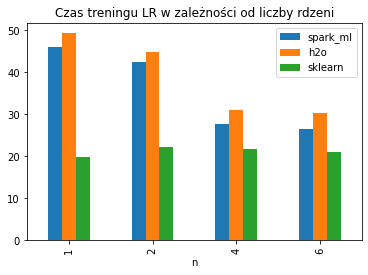

In [29]:
_ = df_train_times.plot.bar(x='n', title='Czas treningu LR w zależności od liczby rdzeni')

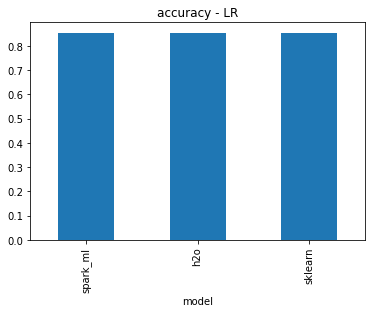

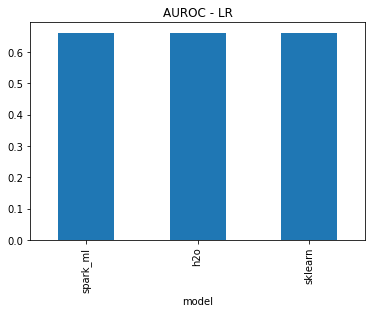

In [30]:
_ = lr_df_metrics.plot.bar(x='model', y='accuracy', title='accuracy - LR', legend=None)
_ = lr_df_metrics.plot.bar(x='model', y='auroc', title='AUROC - LR', legend=None)

# **Wnioski dla logistic regression (pkt 5)**

## punkt a) - które modele się lepiej skalują

Zarówno modele `sparkMl` jak i `h20-sparkling-water` w fazie treningu skalują się podobnie. Ich czasy wykonania zmniejszają się podobnie wraz ze wzrastającą liczbą wątków. Czas LR z SparkML zmniejszył się o 42%, a czas treningu LR z H2O zmniejszył się o 38%. Zastanawiające jest, że o ile czas predykcji SparkML analogicznie zmalał o 41%, to czas predykcji H2O nawet wzrasta wraz dodatkową liczbą wątków. Różnica w czasie predykcji na jednym wątku pomiędzy tymi dwiema implementacjami wynosiła 0.03s na korzyść SparkML, a dla 6 wątków już 0.09s.

Sprawdziliśmy też skalowalność `sklearn` (za pomocą `parallel_backend('threading', n_jobs=num_of_threads)`), jednak nie miało to istotnego przełożenia na wyniki.

## punkt b) - które implementacje są bardziej wydajne

Najwydajniejszy jest `sklearn`, jednak jest to biblioteka dostosowana do zastosowań nierozproszonych. Domyślamy się, że na większej maszynie, z większą liczbą dostępnych rdzeni - niż używany do obliczeń laptop - SparkML dogoniłby SKLearn.

W przypadku bibliotek rozporszonych wydajniejszy jest `sparkMl`.

## punkt c) - czy dla wszystkich modeli wystarczył ten sam pre-processing?

`sklearn` wymagał rzutowania na pandasowy dataframe, pozostałe dwa nie wymagały dodatkowych działań.

### Poniżej dobieraliśmy hiperparametry za pomocą walidacji krzyżowej. W tym momencie zostało zakomentowane, ponieważ wykonanie trwa długo na naszych maszynach.


In [31]:
# lr.explainParams()

In [32]:
# from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
# param_grid = ParamGridBuilder().addGrid(lr.aggregationDepth, [2,3,4]).addGrid(lr.elasticNetParam, [0., 0.5, 1.]).build()
# cv = CrossValidator(estimator=lr, estimatorParamMaps=param_grid, evaluator=evaluator_auroc, numFolds=4)
# cv_model = cv.fit(training)
# best_model = cv_model.bestModel
# pred_cv = best_model.transform(test)
# auroc_cv = evaluator_auroc.evaluate(pred_cv)
# acc_cv = evaluator_acc.evaluate(pred_cv)
# label_and_pred = pred_cv.select('label', 'prediction')
# confusion_matrix = label_and_pred.groupBy('label', 'prediction').count().toPandas()
# print(f"MODEL: {model} AUROC: {auroc_cv} ACCURACY: {acc_cv} CONFUSION MATRIX: ")
# print(confusion_matrix)


# optymalizacja hiperparametrów nic nie daje - wybiera defaultowe 
# Wykonanie tego trwa długo - wystarczy że raz to zrobiliśmy i napiszemy tylko wniosek

.

.

.

.

.




# **XGB**

In [33]:
xgb_models_train_time = {}
xgb_models_pred_time = {}

# **sparkMl - MLlib**

In [34]:
from pyspark.mllib.tree import GradientBoostedTrees

In [35]:
categoricalFeaturesInfo = {}

# ta implementacja potrzebuje słownika {"indeks kolumny": "liczba kategorii"} zeby odróżnić feature'y dyskretne od continous
for idx, column in enumerate(categorical_columns):
    num_of_values = raw_df.select(column).distinct().count()
    categoricalFeaturesInfo[idx] = num_of_values
    
# print(categoricalFeaturesInfo)

In [36]:
#rdd = xgb_df.rdd.map(list) # to nie działa

# Trzeba scastować DF na LabledPoint a niestety nie ma prostej funkcji typu '.toLabeledPoints'.
# To co się dzieje poniżej wzięte stąd:
# https://stackoverflow.com/questions/32556178/create-labeledpoints-from-spark-dataframe-in-python
from pyspark.mllib.regression import LabeledPoint
from pyspark.sql.functions import col

from pyspark.mllib import linalg as mllib_linalg
from pyspark.ml import linalg as ml_linalg

def as_old(v):
    if isinstance(v, ml_linalg.SparseVector):
        return mllib_linalg.SparseVector(v.size, v.indices, v.values)
    if isinstance(v, ml_linalg.DenseVector):
        return mllib_linalg.DenseVector(v.values)
    raise ValueError("Unsupported type {0}".format(type(v)))

labeledPoints = \
    (transformed_df.select(col("label"), col("selectedFeatures"))
      .rdd
      .map(lambda row: LabeledPoint(row.label, as_old(row.selectedFeatures))))

xgb_mllib_training, xgb_mllib_test = labeledPoints.randomSplit([0.8, 0.2], seed=1234)

In [37]:
import time

start_time_training = time.time()
xgb_mllib_model = GradientBoostedTrees.trainClassifier(
    xgb_mllib_training, 
    categoricalFeaturesInfo=categoricalFeaturesInfo,
    numIterations=20
)
xgb_models_train_time['mllib'] = time.time() - start_time_training

start_time_predicting = time.time()
mllib_predictions_rdd = xgb_mllib_model.predict(xgb_mllib_test.map(lambda x: x.features))
xgb_models_pred_time['mllib'] = time.time() - start_time_predicting

In [38]:
# mllib_predictions_rdd.map(lambda r: (r,)).toDF().limit(1).show()

In [40]:
mllib_predictions = mllib_predictions_rdd.collect()
labels = xgb_mllib_test.map(lambda x: x.label).collect()
mllib_label_and_pred = list(zip(labels, mllib_predictions))
mllib_label_and_pred = spark.createDataFrame(mllib_label_and_pred, ["label", "prediction"])

# **H20 sparking water**

In [41]:
from pysparkling.ml import H2OXGBoostClassifier # H2OXGBoost
xgb_h20_model = H2OXGBoostClassifier(labelCol = "label")

In [42]:
start_time_training = time.time()
xgb_h20_model = xgb_h20_model.fit(training)
xgb_models_train_time['h20'] = time.time() - start_time_training

start_time_predicting = time.time()
h20_predictions = xgb_h20_model.transform(test)
xgb_models_pred_time['h20'] = time.time() - start_time_predicting

In [43]:
h20_label_and_pred = h20_predictions \
    .select('label', 'prediction', 'detailed_prediction')\
    .withColumn("prediction", h20_predictions.prediction.cast("double"))

# w celu wydobycia 'rawPrediction' na potrzeby AUROC
def map_func(row):
    if row.prediction == 1.0:
        return (row.label, row.prediction, row.detailed_prediction[1][1])
    else:
        return (row.label, row.prediction, row.detailed_prediction[1][0])

h20_label_and_pred = \
    h20_label_and_pred \
        .rdd \
        .map(lambda r: map_func(r)) \
        .toDF(['label', 'prediction', 'rawPrediction'])

# **SynapseML**

In [44]:
from pyspark.ml.linalg import VectorUDT
from pyspark.sql.functions import udf
dummy_udf = udf(lambda z: z ,VectorUDT()) 
synapse_ml_df = transformed_df.withColumn("selectedFeatures", dummy_udf(col("selectedFeatures")))
# używając udf usuwamy metadata - to jedyna opcja jaka zadziałała

synapse_ml_training, synapse_ml_test = synapse_ml_df["selectedFeatures", "label"].randomSplit([0.8, 0.2], seed=1234)

In [45]:
from synapse.ml.lightgbm import LightGBMClassifier

xgb_synapse_model = LightGBMClassifier(
    objective="binary", 
    featuresCol="selectedFeatures", 
    labelCol="label", 
    isUnbalance=True,
)

In [46]:
start_time_training = time.time()
xgb_synapse_model = xgb_synapse_model.fit(synapse_ml_training)
xgb_models_train_time['synapse'] = time.time() - start_time_training

start_time_predicting = time.time()
synapse_predictions = xgb_synapse_model.transform(synapse_ml_test)
xgb_models_pred_time['synapse'] = time.time() - start_time_predicting

In [47]:
synapse_label_and_pred = synapse_predictions.select('label', 'prediction', 'rawPrediction', 'probability')

# Liczenie metryk dla XGB

In [48]:
xgb_models_predictions = {"mllib": mllib_label_and_pred, "h20": h20_label_and_pred, "synapse": synapse_label_and_pred}

In [49]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
xgb_evaluator_auroc = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", metricName="areaUnderROC")
xgb_evaluator_acc = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

In [50]:
xgb_df_metrics = pd.DataFrame()
for model in xgb_models_predictions:
    print(f"MODEL: {model}")
    label_and_pred = xgb_models_predictions[model]
    confusion_matrix = label_and_pred.groupBy('label', 'prediction').count().toPandas()
    if model == 'mllib':
        auroc = 0
    else:
        auroc = xgb_evaluator_auroc.evaluate(label_and_pred)
    
    accuracy = xgb_evaluator_acc.evaluate(label_and_pred)
    
    print(f"AUROC: {auroc} \nACCURACY: {accuracy} \nCONFUSION MATRIX: \n{confusion_matrix} \n")
    
    metrics_dict = {'model': model, 'auroc': auroc, 'accuracy': accuracy}
    xgb_df_metrics = pd.concat([xgb_df_metrics, pd.DataFrame([metrics_dict])], ignore_index=True)

MODEL: mllib
AUROC: 0 
ACCURACY: 0.8497531983479399 
CONFUSION MATRIX: 
   label  prediction  count
0    1.0         1.0  16864
1    0.0         1.0   2979
2    1.0         0.0      4
3    0.0         0.0      7 

MODEL: h20
AUROC: 0.6846388948658495 
ACCURACY: 0.8531999396712081 
CONFUSION MATRIX: 
   label  prediction  count
0    1.0         1.0  16900
1    0.0         1.0   2856
2    1.0         0.0     64
3    0.0         0.0     71 

MODEL: synapse
AUROC: 0.6866708108418583 
ACCURACY: 0.6492886229953245 
CONFUSION MATRIX: 
   label  prediction  count
0    1.0         0.0   5889
1    0.0         0.0   1840
2    1.0         1.0  11075
3    0.0         1.0   1087 



In [51]:
print(xgb_models_train_time)
print(xgb_models_pred_time)

{'mllib': 25.532210111618042, 'h20': 16.793867826461792, 'synapse': 19.857619762420654}
{'mllib': 0.06154584884643555, 'h20': 0.035439252853393555, 'synapse': 0.09436869621276855}


In [52]:
# Policzone dla e5 - średniej wielkości zbioru

# dla N=1
n_1_train = {'n': 1, 'mllib': 18.438204050064087, 'h20': 17.530575275421143, 'synapse': 16.685768365859985}
n_1_predict = {'n': 1, 'mllib': 0.03271126747131348, 'h20': 0.018050670623779297, 'synapse': 0.044275760650634766}

# dla N=2
n_2_train = {'n': 2, 'mllib': 22.360747814178467, 'h20': 15.743622779846191, 'synapse': 12.809144496917725}
n_2_predict = {'n': 2, 'mllib': 0.04076576232910156, 'h20': 0.05380558967590332, 'synapse': 0.043966054916381836}

# dla N=4
n_4_train = {'n': 4, 'mllib': 19.790700435638428, 'h20': 13.06553602218628, 'synapse': 9.688252925872803}
n_4_predict = {'n': 4, 'mllib': 0.03688383102416992, 'h20': 0.06297636032104492, 'synapse': 0.04892086982727051}

# dla N=6(moja [*] )
n_6_train = {'n': 6, 'mllib': 17.05766534805298, 'h20': 11.285520553588867, 'synapse': 9.767557144165039}
n_6_predict = {'n': 6, 'mllib': 0.04061126708984375, 'h20': 0.019430875778198242, 'synapse': 0.06539630889892578}

train_times = [n_1_train, n_2_train, n_4_train, n_6_train]
predict_times = [n_1_predict, n_2_predict, n_4_predict, n_6_predict]

In [53]:
df_train_times = pd.DataFrame()
for r in train_times:
    new_row_df = pd.DataFrame([r])
    df_train_times = pd.concat([df_train_times, new_row_df], ignore_index=True)

df_predict_times = pd.DataFrame()
for r in predict_times:
    new_row_df = pd.DataFrame([r])
    df_predict_times = pd.concat([df_predict_times, new_row_df], ignore_index=True)

In [54]:
import matplotlib.pyplot as plt

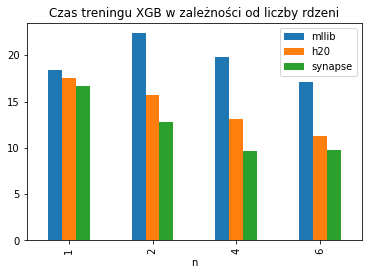

In [55]:
_ = df_train_times.plot.bar(x='n', title='Czas treningu XGB w zależności od liczby rdzeni')

## Note: sparkMl mllib nie zwraca niczego na wzór `rawPrediction`. Nie ma sensu zrównywać tej metryki z pozostałymi modelami.

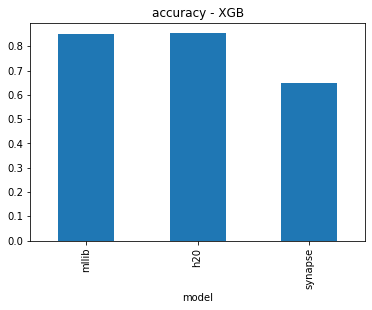

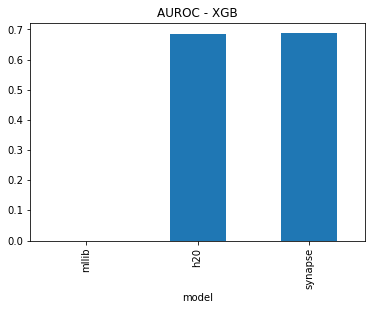

In [56]:
_ = xgb_df_metrics.plot.bar(x='model', y='accuracy', title='accuracy - XGB', legend=None)
_ = xgb_df_metrics.plot.bar(x='model', y='auroc', title='AUROC - XGB', legend=None)

# **Wnioski dla XGB (pkt 5)**

## punkt a)

- `synapse` sklauje się najlepiej - czas treningu zmiejszył się o 41%
- `h20` niewiele gorzej - czas treningu zmiejszył się o 36%
- z `mllib` na pewno gorzej niż dwa pozostałe. Podczas zmiany liczby wątków z 1 na 2 czas wykonania wzrósł zamiast zmaleć. Wraz z kolejnym dodawaniem wątków czas spadał analogicznie do pozostałych implementacji. 

## punkt b)

podobnie jak w przypadku skalowania: `synapse` najepszy, potem `h20` na końcu `mllib`.

## punkt c)

- `mllib` wymagał transformacji DataFrame do RDD złożonego z `LabeledPoint`. Została wykonana zgodnei z https://stackoverflow.com/questions/32556178/create-labeledpoints-from-spark-dataframe-in-python
- `h20` nie wymagał dodatkowych akcji
- `synapse` wymagało modyfikacji metadanych. W metadanych kolumny wektorów cech `selectedFeatures`, były zapisane informacje o składowych kolumnach w formacie JSON, co bardzo nie podobało się `synapse`. Poradziliśmy sobie całkowitym usunięciem metadanych (co też nie było takie oczywiste, bo API do metadanych DataFrame zostało wprowadzone dopiero od wersji 3.3 Sparka).

## Skuteczność (wniosek o modelach LR i GradientBoost)

Wszystkie modele pozwalają uzyskać bardzo podobne wyniki (AUROC ~ (0.66-0.69). Automatyczna selekcja cech i optymalizacja hiperparametrów nie pozwoliły nam poprawić skuteczności modeli. Zaobserwowaliśmy niezbalansowanie klas w stosunku 1:5.71, które powoduje, że modele prawie zawsze zwracają klasę większościową. Próby walki z niezbalansowaniem klas poprzez ręczny oversampling/undersampling bądź algorytmy wbudowane w modele biblioteczne (np. deklarując isUnbalance=True w konstuktorze) pozostawiają AUROC na prawie tym samym poziomie, natomiast znacznie obniżają metrykę `accuracy`. Pozostaje nam odwołać się do klasycznej wymówki data scientista - dane nie pozwoliły więcej wycisnąć. 

In [57]:
spark.stop()